In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Base directory where datasets are stored
dir_baseline = '../checkpoints/result/'
dir_density_Grad = '../checkpoints/result_density_Grad/'
dir_Opacity = '../checkpoints/result_Opacity/'
dir_rgbW = '../checkpoints/result_rgbW/'
dir_density_rgbW = '../checkpoints/result_density_rgbW/'
datasets = ['Beauty', 'HoneyBee', 'Jockey']



In [3]:
def parse_train_txt(train_txt_path):
    with open(train_txt_path, 'r') as file:
        lines = file.readlines()
        last_line = lines[-1].strip()
        data = last_line.split(',')
        result = {
            'PSNR': float(data[1].split(':')[-1]),
            'MS-SSIM': float(data[2].split(':')[-1]),
            'Training': float(data[3].split(':')[-1][:-1]),
            'Eval': float(data[4].split(':')[-1][:-1]),
            'FPS': float(data[5].split(':')[-1]),
            'Size': float(data[6].split(':')[-1]),
            'Gaussian_number':float(data[-1].split(':')[-1])
        }    
    return result

In [4]:

# List to store results
results_baseline = []
results_density_Grad = []
results_Opacity = []
results_rgbW = []
results_density_rgbW = []
# Loop through datasets and collect data from train.txt files
def get_method_data(dir_path):
    results = []
    for dataset in datasets:
        dataset_path = os.path.join(dir_path, dataset)
        for dir_name in os.listdir(dataset_path):
            if dir_name.startswith('GaussianImage_Cholesky'):
                train_txt_path = os.path.join(dataset_path, dir_name, 'train.txt')
                result= parse_train_txt(train_txt_path)
                result['Dataset'] = dataset
                if result['Gaussian_number']>=20000:
                    results.append(result)
    return results

results_baseline = get_method_data(dir_baseline)
results_density_Grad= get_method_data(dir_density_Grad)
results_Opacity= get_method_data(dir_Opacity)
results_rgbW= get_method_data(dir_rgbW)
results_density_rgbW= get_method_data(dir_density_rgbW)


df_baseline = pd.DataFrame(results_baseline)
df_density_Grad = pd.DataFrame(results_density_Grad)
df_Opacity = pd.DataFrame(results_Opacity)
df_rgbW = pd.DataFrame(results_rgbW)
df_density_rgbW = pd.DataFrame(results_density_rgbW)


# # Sort the results by GaussianCount before converting to DataFrame
# results_sorted_new_method_5 = sorted(results_new_method_5, key=lambda x: x['Gaussian_number'])



In [5]:
def plot_gaussian_vs_metrics(df_baseline, df_density_Grad, df_Opacity, df_rgbW,df_density_rgbW):
# def plot_gaussian_vs_metrics(df_baseline, df_new_method_1, df_new_method_2):
    for dataset in datasets:
        # 按 GaussianCount 排序确保一致
        subset_df_baseline = df_baseline[df_baseline['Dataset'] == dataset].sort_values(by='Gaussian_number')
        subset_df_density_Grad = df_density_Grad[df_density_Grad['Dataset'] == dataset].sort_values(by='Gaussian_number')
        subset_df_Opacity = df_Opacity[df_Opacity['Dataset'] == dataset].sort_values(by='Gaussian_number')
        subset_df_rgbW = df_rgbW[df_rgbW['Dataset'] == dataset].sort_values(by='Gaussian_number')
        subset_df_density_rgbW = df_density_rgbW[df_density_rgbW['Dataset'] == dataset].sort_values(by='Gaussian_number')

        plt.figure(figsize=(11, 5))

        # 第一个子图：Gaussian count vs PSNR
        plt.subplot(1, 2, 1)

        # 添加散点图和连线
        plt.scatter(subset_df_Opacity['Gaussian_number'], subset_df_Opacity['PSNR'], 
                    color='#1f77b4', alpha=0.7, s=50, label='Opacity', edgecolor='black')
        plt.scatter(subset_df_rgbW['Gaussian_number'], subset_df_rgbW['PSNR'], 
                    color='#ff7f0e', alpha=0.7, s=50, label='rgbW', edgecolor='black')
        plt.scatter(subset_df_density_Grad['Gaussian_number'], subset_df_density_Grad['PSNR'], 
                    color='#d62728', alpha=0.7, s=50, label='Adaptive_Control(Grad)', edgecolor='black')
        plt.scatter(subset_df_density_rgbW['Gaussian_number'], subset_df_density_rgbW['PSNR'], 
                    color='#9467bd', alpha=0.7, s=50, label='Adaptive_Control(rgbW)', edgecolor='black')
        plt.scatter(subset_df_baseline['Gaussian_number'], subset_df_baseline['PSNR'], 
                    color='#17becf', alpha=0.7, s=50, label='Baseline', edgecolor='black')

        # 绘制连线
        plt.plot(subset_df_Opacity['Gaussian_number'], subset_df_Opacity['PSNR'], 
                color='#1f77b4', alpha=0.5)
        plt.plot(subset_df_rgbW['Gaussian_number'], subset_df_rgbW['PSNR'], 
                color='#ff7f0e', alpha=0.5)
        plt.plot(subset_df_density_Grad['Gaussian_number'], subset_df_density_Grad['PSNR'], 
                color='#d62728', alpha=0.5)
        plt.plot(subset_df_density_rgbW['Gaussian_number'], subset_df_density_rgbW['PSNR'], 
                color='#9467bd', alpha=0.5)
        plt.plot(subset_df_baseline['Gaussian_number'], subset_df_baseline['PSNR'], 
                color='#17becf', alpha=0.5)
                
        



        # 添加标题和标签
        plt.xlabel('Gaussian Number', fontsize=14, fontweight='bold')
        plt.ylabel('PSNR (dB)', fontsize=14, fontweight='bold')
        plt.title(f'{dataset} - Gaussian Number vs PSNR', fontsize=16, fontweight='bold')

        # 调整 X 轴刻度和网格
        # plt.xticks(range(4000, 10000, 2000))
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend()

        # 第二个子图：Gaussian count vs MS-SSIM
        plt.subplot(1, 2, 2)
     
        
        # 添加散点图和连线
        plt.scatter(subset_df_Opacity['Gaussian_number'], subset_df_Opacity['MS-SSIM'], 
                    color='#1f77b4', alpha=0.7, s=50, label='Opacity', edgecolor='black')
        plt.scatter(subset_df_rgbW['Gaussian_number'], subset_df_rgbW['MS-SSIM'], 
                    color='#ff7f0e', alpha=0.7, s=50, label='rgbW', edgecolor='black')
        plt.scatter(subset_df_density_Grad['Gaussian_number'], subset_df_density_Grad['MS-SSIM'], 
                    color='#d62728', alpha=0.7, s=50, label='Adaptive_Control(Grad)', edgecolor='black')
        plt.scatter(subset_df_density_rgbW['Gaussian_number'], subset_df_density_rgbW['MS-SSIM'], 
                    color='#9467bd', alpha=0.7, s=50, label='Adaptive_Control(rgbW)', edgecolor='black')
        plt.scatter(subset_df_baseline['Gaussian_number'], subset_df_baseline['MS-SSIM'], 
                    color='#17becf', alpha=0.7, s=50, label='Baseline', edgecolor='black')

        # 绘制连线
        plt.plot(subset_df_Opacity['Gaussian_number'], subset_df_Opacity['MS-SSIM'], 
                color='#1f77b4', alpha=0.5)
        plt.plot(subset_df_rgbW['Gaussian_number'], subset_df_rgbW['MS-SSIM'], 
                color='#ff7f0e', alpha=0.5)
        plt.plot(subset_df_density_Grad['Gaussian_number'], subset_df_density_Grad['MS-SSIM'], 
                color='#d62728', alpha=0.5)
        plt.plot(subset_df_density_rgbW['Gaussian_number'], subset_df_density_rgbW['MS-SSIM'], 
                color='#9467bd', alpha=0.5)
        plt.plot(subset_df_baseline['Gaussian_number'], subset_df_baseline['MS-SSIM'], 
                color='#17becf', alpha=0.5)
        


        # 添加标题和标签
        plt.xlabel('Gaussian Number', fontsize=14, fontweight='bold')
        plt.ylabel('MS-SSIM', fontsize=14, fontweight='bold')
        plt.title(f'{dataset} - Gaussian Number vs MS-SSIM', fontsize=16, fontweight='bold')

        # 调整 X 轴刻度和网格
        # plt.xticks(range(4000, 10001, 2000))
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend()

        # 布局调整
        plt.tight_layout()

        # 保存图像
        plt.savefig(f'./img_compare/{dataset}_gaussian_vs_metrics.png')

        # 显示图像
        plt.show()


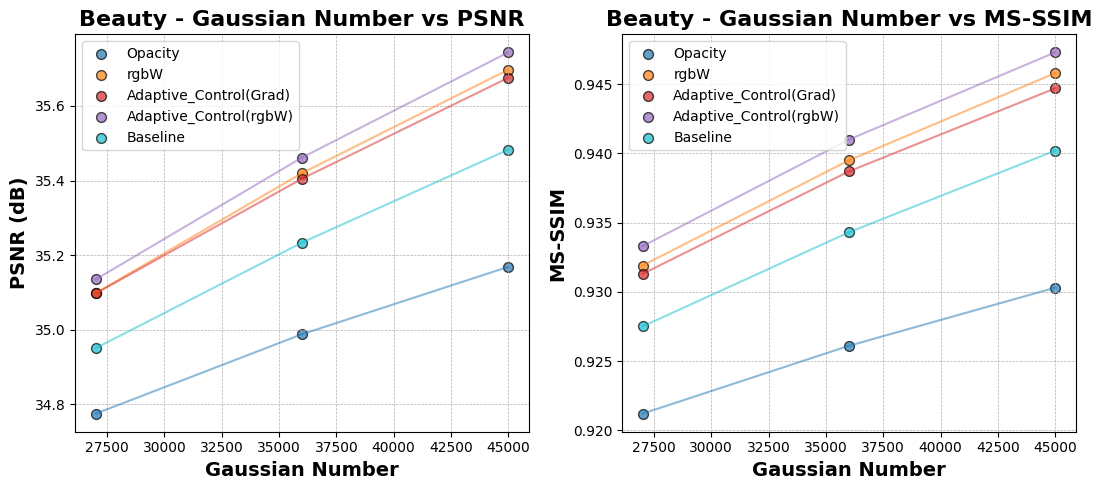

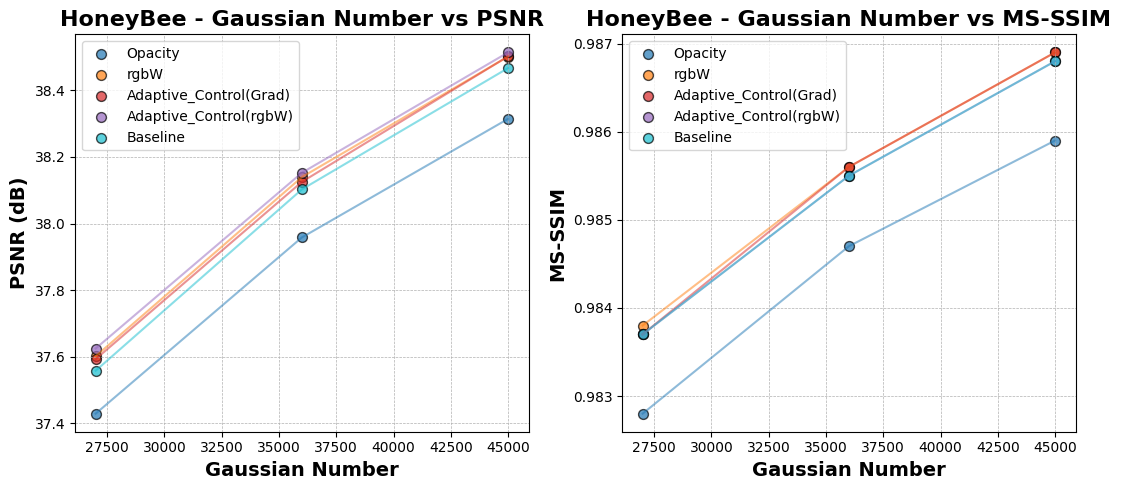

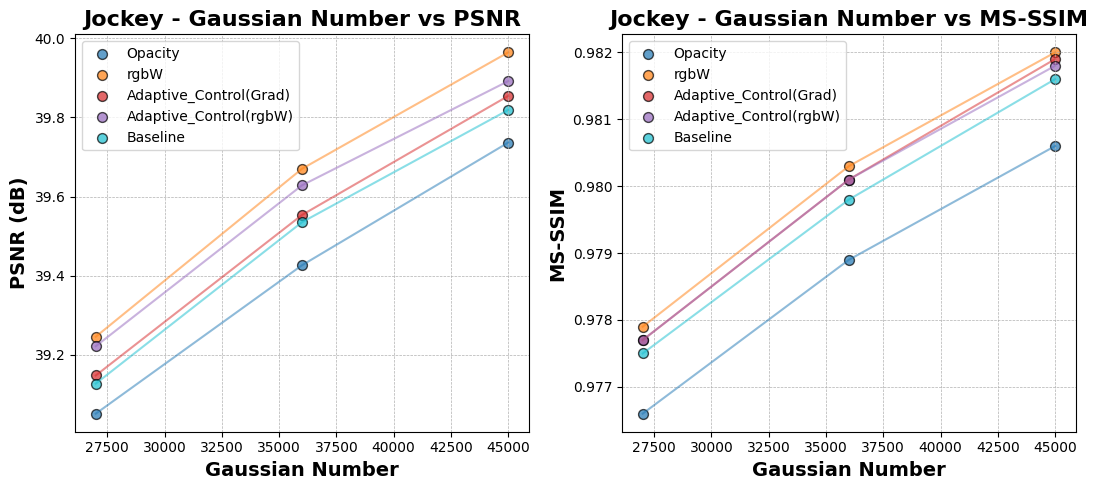

In [6]:
plot_gaussian_vs_metrics(df_baseline, df_density_Grad, df_Opacity, df_rgbW,df_density_rgbW)